/Users/h1he2li3/opt/anaconda3/envs/dymos_rangemax/lib/python3.11/site-packages/pycycle/thermo/static_ps_resid.py:128: RuntimeWarning: invalid value encountered in sqrt
  Vsonic = (i['gamma']*i['R']*i['Ts'])**0.5





----------------------------------------------------------------------------
                              POINT: DESIGN
----------------------------------------------------------------------------
                       PERFORMANCE CHARACTERISTICS
    Mach      Alt       W      Fn      Fg    Fram     OPR     TSFC  
 0.00000      0.0 147.333 11800.0 11800.0     0.0  13.500  0.79852
------------------------------------------------------------------------------------------------------------------------------------------------
                            FLOW STATIONS
------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------
Flow Station           |          tot:P        tot:T        tot:h        tot:S       stat:P       stat:W      stat:MN       stat:V    s

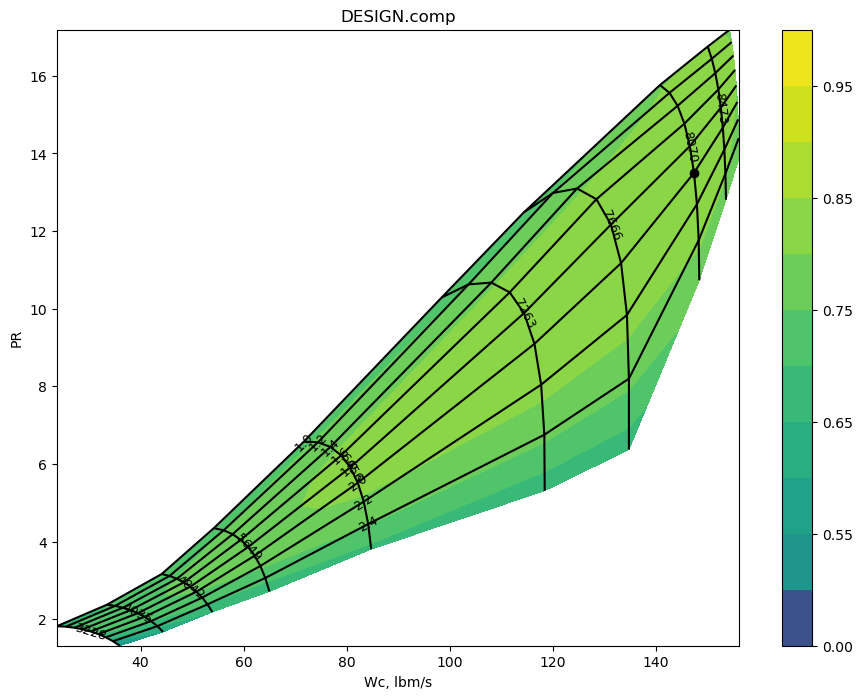

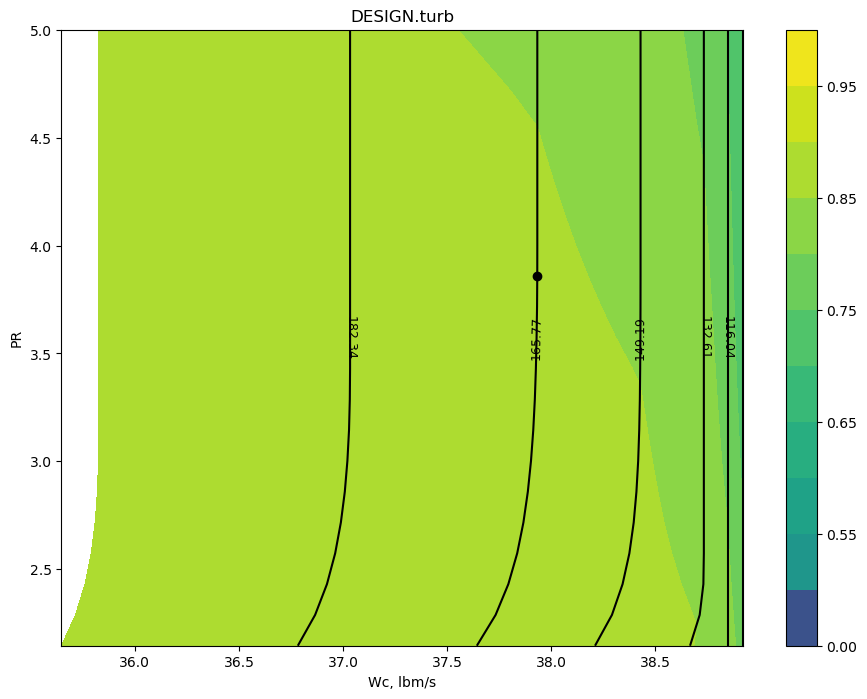

In [1]:
import sys

import openmdao.api as om

import pycycle.api as pyc


class Turbojet(pyc.Cycle):

    def setup(self):

        USE_TABULAR = True

        if USE_TABULAR: 
            self.options['thermo_method'] = 'TABULAR'
            self.options['thermo_data'] = pyc.AIR_JETA_TAB_SPEC
            FUEL_TYPE = "FAR"
        else: 
            self.options['thermo_method'] = 'CEA'
            self.options['thermo_data'] = pyc.species_data.janaf
            FUEL_TYPE = "Jet-A(g)"

        design = self.options['design']

        # Add engine elements
        self.add_subsystem('fc', pyc.FlightConditions())
        self.add_subsystem('inlet', pyc.Inlet())
        self.add_subsystem('comp', pyc.Compressor(map_data=pyc.AXI5, map_extrap=True),
                                    promotes_inputs=['Nmech'])
        self.add_subsystem('burner', pyc.Combustor(fuel_type=FUEL_TYPE))
        self.add_subsystem('turb', pyc.Turbine(map_data=pyc.LPT2269),
                                    promotes_inputs=['Nmech'])
        self.add_subsystem('nozz', pyc.Nozzle(nozzType='CD', lossCoef='Cv'))
        self.add_subsystem('shaft', pyc.Shaft(num_ports=2),promotes_inputs=['Nmech'])
        self.add_subsystem('perf', pyc.Performance(num_nozzles=1, num_burners=1))

        # Connect flow stations
        self.pyc_connect_flow('fc.Fl_O', 'inlet.Fl_I', connect_w=False)
        self.pyc_connect_flow('inlet.Fl_O', 'comp.Fl_I')
        self.pyc_connect_flow('comp.Fl_O', 'burner.Fl_I')
        self.pyc_connect_flow('burner.Fl_O', 'turb.Fl_I')
        self.pyc_connect_flow('turb.Fl_O', 'nozz.Fl_I')

        # Make other non-flow connections
        # Connect turbomachinery elements to shaft
        self.connect('comp.trq', 'shaft.trq_0')
        self.connect('turb.trq', 'shaft.trq_1')

        # Connnect nozzle exhaust to freestream static conditions
        self.connect('fc.Fl_O:stat:P', 'nozz.Ps_exhaust')

        # Connect outputs to perfomance element
        self.connect('inlet.Fl_O:tot:P', 'perf.Pt2')
        self.connect('comp.Fl_O:tot:P', 'perf.Pt3')
        self.connect('burner.Wfuel', 'perf.Wfuel_0')
        self.connect('inlet.F_ram', 'perf.ram_drag')
        self.connect('nozz.Fg', 'perf.Fg_0')

        # Add balances for design and off-design
        balance = self.add_subsystem('balance', om.BalanceComp())
        if design:

            balance.add_balance('W', units='lbm/s', eq_units='lbf', rhs_name='Fn_target')
            self.connect('balance.W', 'inlet.Fl_I:stat:W')
            self.connect('perf.Fn', 'balance.lhs:W')

            balance.add_balance('FAR', eq_units='degR', lower=1e-4, val=.017, rhs_name='T4_target')
            self.connect('balance.FAR', 'burner.Fl_I:FAR')
            self.connect('burner.Fl_O:tot:T', 'balance.lhs:FAR')

            balance.add_balance('turb_PR', val=1.5, lower=1.001, upper=8, eq_units='hp', rhs_val=0.)
            self.connect('balance.turb_PR', 'turb.PR')
            self.connect('shaft.pwr_net', 'balance.lhs:turb_PR')

        else:

            balance.add_balance('FAR', eq_units='lbf', lower=1e-4, val=.3, rhs_name='Fn_target')
            self.connect('balance.FAR', 'burner.Fl_I:FAR')
            self.connect('perf.Fn', 'balance.lhs:FAR')

            balance.add_balance('Nmech', val=1.5, units='rpm', lower=500., eq_units='hp', rhs_val=0.)
            self.connect('balance.Nmech', 'Nmech')
            self.connect('shaft.pwr_net', 'balance.lhs:Nmech')

            balance.add_balance('W', val=168.0, units='lbm/s', eq_units='inch**2')
            self.connect('balance.W', 'inlet.Fl_I:stat:W')
            self.connect('nozz.Throat:stat:area', 'balance.lhs:W')

       
        newton = self.nonlinear_solver = om.NewtonSolver()
        newton.options['atol'] = 1e-6
        newton.options['rtol'] = 1e-6
        newton.options['iprint'] = 2
        newton.options['maxiter'] = 15
        newton.options['solve_subsystems'] = True
        newton.options['max_sub_solves'] = 100
        newton.options['reraise_child_analysiserror'] = False
        
        self.linear_solver = om.DirectSolver()

        super().setup()

def viewer(prob, pt, file=sys.stdout):
    """
    print a report of all the relevant cycle properties
    """

    summary_data = (prob[pt+'.fc.Fl_O:stat:MN'], prob[pt+'.fc.alt'], prob[pt+'.inlet.Fl_O:stat:W'], 
                    prob[pt+'.perf.Fn'], prob[pt+'.perf.Fg'], prob[pt+'.inlet.F_ram'],
                    prob[pt+'.perf.OPR'], prob[pt+'.perf.TSFC'])

    print(file=file, flush=True)
    print(file=file, flush=True)
    print(file=file, flush=True)
    print("----------------------------------------------------------------------------", file=file, flush=True)
    print("                              POINT:", pt, file=file, flush=True)
    print("----------------------------------------------------------------------------", file=file, flush=True)
    print("                       PERFORMANCE CHARACTERISTICS", file=file, flush=True)
    print("    Mach      Alt       W      Fn      Fg    Fram     OPR     TSFC  ", file=file, flush=True)
    print(" %7.5f  %7.1f %7.3f %7.1f %7.1f %7.1f %7.3f  %7.5f" %summary_data, file=file, flush=True)


    fs_names = ['fc.Fl_O', 'inlet.Fl_O', 'comp.Fl_O', 'burner.Fl_O',
                'turb.Fl_O', 'nozz.Fl_O']
    fs_full_names = [f'{pt}.{fs}' for fs in fs_names]
    pyc.print_flow_station(prob, fs_full_names, file=file)

    comp_names = ['comp']
    comp_full_names = [f'{pt}.{c}' for c in comp_names]
    pyc.print_compressor(prob, comp_full_names, file=file)

    pyc.print_burner(prob, [f'{pt}.burner'])

    turb_names = ['turb']
    turb_full_names = [f'{pt}.{t}' for t in turb_names]
    pyc.print_turbine(prob, turb_full_names, file=file)

    noz_names = ['nozz']
    noz_full_names = [f'{pt}.{n}' for n in noz_names]
    pyc.print_nozzle(prob, noz_full_names, file=file)

    shaft_names = ['shaft']
    shaft_full_names = [f'{pt}.{s}' for s in shaft_names]
    pyc.print_shaft(prob, shaft_full_names, file=file)

def map_plots(prob, pt):
    comp_names = ['comp']
    comp_full_names = [f'{pt}.{c}' for c in comp_names]
    pyc.plot_compressor_maps(prob, comp_full_names)

    turb_names = ['turb']
    turb_full_names = [f'{pt}.{c}' for c in turb_names]
    pyc.plot_turbine_maps(prob, turb_full_names)



class MPTurbojet(pyc.MPCycle):

    def setup(self):

        # Create design instance of model
        self.pyc_add_pnt('DESIGN', Turbojet())

        self.set_input_defaults('DESIGN.Nmech', 8070.0, units='rpm')
        self.set_input_defaults('DESIGN.inlet.MN', 0.60)
        self.set_input_defaults('DESIGN.comp.MN', 0.020)#.2
        self.set_input_defaults('DESIGN.burner.MN', 0.020)#.2
        self.set_input_defaults('DESIGN.turb.MN', 0.4)

        self.pyc_add_cycle_param('burner.dPqP', 0.03)
        self.pyc_add_cycle_param('nozz.Cv', 0.99)

        
        # define the off-design conditions we want to run
        self.od_pts = ['OD0', 'OD1']
        self.od_MNs = [0.000001, 0.2]
        self.od_alts = [0.0, 5000]
        self.od_Fns =[11000.0, 8000.0]

        for i,pt in enumerate(self.od_pts):
            self.pyc_add_pnt(pt, Turbojet(design=False))

            self.set_input_defaults(pt+'.fc.MN', val=self.od_MNs[i])
            self.set_input_defaults(pt+'.fc.alt', self.od_alts[i], units='ft')
            self.set_input_defaults(pt+'.balance.Fn_target', self.od_Fns[i], units='lbf')  

        self.pyc_use_default_des_od_conns()

        self.pyc_connect_des_od('nozz.Throat:stat:area', 'balance.rhs:W')

        super().setup()

if __name__ == "__main__":

    import time

    prob = om.Problem()


    mp_turbojet = prob.model = MPTurbojet()

    # prob.model.set_order(['DESIGN', 'OD0', 'OD1', 'test')

    prob.setup(check=False)

    #Define the design point
    prob.set_val('DESIGN.fc.alt', 0, units='ft')
    prob.set_val('DESIGN.fc.MN', 0.000001)
    prob.set_val('DESIGN.balance.Fn_target', 11800.0, units='lbf')
    prob.set_val('DESIGN.balance.T4_target', 2370.0, units='degR') 
    prob.set_val('DESIGN.comp.PR', 13.5) 
    prob.set_val('DESIGN.comp.eff', 0.83)
    prob.set_val('DESIGN.turb.eff', 0.86)

    # Set initial guesses for balances
    prob['DESIGN.balance.FAR'] = 0.0175506829934
    prob['DESIGN.balance.W'] = 168.453135137
    prob['DESIGN.balance.turb_PR'] = 4.46138725662
    prob['DESIGN.fc.balance.Pt'] = 14.6955113159
    prob['DESIGN.fc.balance.Tt'] = 518.665288153

    for i,pt in enumerate(mp_turbojet.od_pts):

        # initial guesses
        prob[pt+'.balance.W'] = 166.073
        prob[pt+'.balance.FAR'] = 0.01680
        prob[pt+'.balance.Nmech'] = 8197.38
        prob[pt+'.fc.balance.Pt'] = 15.703
        prob[pt+'.fc.balance.Tt'] = 558.31
        prob[pt+'.turb.PR'] = 4.6690

    st = time.time()

    prob.set_solver_print(level=-1)
    prob.set_solver_print(level=2, depth=1)

    # prob.model.OD1.nonlinear_solver.options['maxiter'] = 1

    prob.run_model()

    # prob.model.OD1.list_outputs(residuals=True)
    # exit()

    for pt in ['DESIGN']+mp_turbojet.od_pts:
        viewer(prob, pt)

    map_plots(prob,'DESIGN')

    print()
    print("time", time.time() - st)